In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot as gplt
import geoplot.crs as gcrs

%matplotlib inline

## Introduction
In this notebook I use the area weighting method to convert data aggregated by census block (in this case, census return rates) to a the larger neighborhood polygons defined the Hack OR Disaster Team. Metrics such as ratios cannot use the block centroid method since they cannot be allocated by population. The block centroid method is best used on metrics such as counts or sums which make more sense to allocate by population.

As discussed earlier in the season, we explore census return rates here because they have been found in some [literature](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.1019.2188&rep=rep1&type=pdf) to have a strong relationship with indicators of social capital. 

In [2]:
# start of by getting the block groups
or_bg = gpd.read_file("../data/ACS/cb_2016_41_bg_500k/cb_2016_41_bg_500k.shp")

In [3]:
or_bg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2628 entries, 0 to 2627
Data columns (total 11 columns):
STATEFP     2628 non-null object
COUNTYFP    2628 non-null object
TRACTCE     2628 non-null object
BLKGRPCE    2628 non-null object
AFFGEOID    2628 non-null object
GEOID       2628 non-null object
NAME        2628 non-null object
LSAD        2628 non-null object
ALAND       2628 non-null int64
AWATER      2628 non-null int64
geometry    2628 non-null object
dtypes: int64(2), object(9)
memory usage: 225.9+ KB


In [4]:
or_bg.head(3)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,41,005,020900,1,1500000US410050209001,410050209001,1,BG,443749,0,"POLYGON ((-122.63656 45.461474, -122.626278 45..."
1,41,047,002102,2,1500000US410470021022,410470021022,2,BG,287579,0,"POLYGON ((-123.05852 44.89242, -123.0575 44.89..."
2,41,029,000601,2,1500000US410290006012,410290006012,2,BG,2039310,0,"POLYGON ((-122.840623 42.32259699999999, -122...."


In [5]:
# read in census response rate from planning database
pdb = pd.read_csv("../data/census planning db/pdb2016bgv8_us/pdb2016bgv8_us.csv")

In [6]:
pdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220357 entries, 0 to 220356
Columns: 344 entries, GIDBG to pct_BILQ_Mailout_count_CEN_2010
dtypes: float64(321), int64(5), object(18)
memory usage: 578.3+ MB


In [7]:
# Full FIPS county code (last 3 are county specific)
# 41051 Multnomah
# 41067 Washington
# 41005 Clackamas

# subset the pdb by pdx area counties
pdx_counties = ['Multnomah County', 'Clackamas County', 'Washington County']
pdx_pdb = pdb[(pdb['County_name'].isin(pdx_counties)) & (pdb['State_name']=='Oregon')]

In [8]:
pdx_pdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1041 entries, 162181 to 164680
Columns: 344 entries, GIDBG to pct_BILQ_Mailout_count_CEN_2010
dtypes: float64(321), int64(5), object(18)
memory usage: 2.7+ MB


In [9]:
pdx_pdb[:6].head()

,GIDBG,State,State_name,County,County_name,Tract,Block_group,Flag,LAND_AREA,AIAN_LAND,...,pct_TEA_MailOutMailBack_CEN_2010,pct_TEA_Update_Leave_CEN_2010,pct_Census_Mail_Returns_CEN_2010,pct_Vacants_CEN_2010,pct_Deletes_CEN_2010,pct_Census_UAA_CEN_2010,pct_Mailback_Count_CEN_2010,pct_FRST_FRMS_CEN_2010,pct_RPLCMNT_FRMS_CEN_2010,pct_BILQ_Mailout_count_CEN_2010
162181,410050201001,41,Oregon,5,Clackamas County,20100,1,NaN,1.276,0.0,...,100.0,NaN,79.38,2.42,0.0,7.83,89.75,79.38,0.0,NaN
162182,410050201002,41,Oregon,5,Clackamas County,20100,2,NaN,0.319,0.0,...,100.0,NaN,70.70,2.97,0.0,9.77,87.26,70.70,0.0,NaN
162183,410050201003,41,Oregon,5,Clackamas County,20100,3,NaN,0.164,0.0,...,100.0,NaN,58.35,7.07,0.0,18.47,74.46,58.35,0.0,NaN
162184,410050202001,41,Oregon,5,Clackamas County,20200,1,NaN,0.305,0.0,...,100.0,NaN,75.30,1.99,0.0,6.18,91.83,75.30,0.0,NaN
162185,410050202002,41,Oregon,5,Clackamas County,20200,2,NaN,0.953,0.0,...,100.0,NaN,82.21,1.69,0.0,6.37,91.95,82.21,0.0,NaN


In [10]:
pdx_pdb['GIDBG'] = pdx_pdb['GIDBG'].astype(str) 
pdx_bg_data = or_bg.merge(pdx_pdb[['GIDBG','Mail_Return_Rate_CEN_2010','County_name']],
              left_on='GEOID', right_on='GIDBG', how='inner')


C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [11]:
pdx_bg_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1041 entries, 0 to 1040
Data columns (total 14 columns):
STATEFP                      1041 non-null object
COUNTYFP                     1041 non-null object
TRACTCE                      1041 non-null object
BLKGRPCE                     1041 non-null object
AFFGEOID                     1041 non-null object
GEOID                        1041 non-null object
NAME                         1041 non-null object
LSAD                         1041 non-null object
ALAND                        1041 non-null int64
AWATER                       1041 non-null int64
geometry                     1041 non-null object
GIDBG                        1041 non-null object
Mail_Return_Rate_CEN_2010    1040 non-null float64
County_name                  1041 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 122.0+ KB


In [12]:
pdx_bg_data.head(5)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,GIDBG,Mail_Return_Rate_CEN_2010,County_name
0,41,005,020900,1,1500000US410050209001,410050209001,1,BG,443749,0,"POLYGON ((-122.63656 45.461474, -122.626278 45...",410050209001,82.8,Clackamas County
1,41,051,010100,3,1500000US410510101003,410510101003,3,BG,781464,0,"POLYGON ((-122.444858 45.519108, -122.433785 4...",410510101003,83.8,Multnomah County
2,41,067,030801,2,1500000US410670308012,410670308012,2,BG,861388,0,"POLYGON ((-122.779888 45.41419399999999, -122....",410670308012,85.3,Washington County
3,41,051,009907,1,1500000US410510099071,410510099071,1,BG,314973,0,"POLYGON ((-122.425808 45.49803499999999, -122....",410510099071,75.3,Multnomah County
4,41,051,000801,2,1500000US410510008012,410510008012,2,BG,449623,0,"POLYGON ((-122.611124 45.505302, -122.608992 4...",410510008012,75.9,Multnomah County


Now we have the census response rate of all the pdx area block groups. For metrics like rates and (unlike totals or counts), we can use area weighting instead of block centroid allocation. We need to calculate the overlap of every block group and neighborhood intersection, take the ratio of the overlap area of the intersection as a % of the neighborhood area, and apply that ratio to the census response rate.

In [13]:
# load disaster neighborhood shapes (after Adrien cleaned slivers/errors on 5/28)

#pdx_hoods = gpd.read_file("../data/disaster_neighborhoods/RLIS_ST_clips_pdx_jurisa_FIXED.dbf")
pdx_hoods = gpd.read_file("./Data/DisasterNeighborhoods_FIXED_final/RLIS_ST_clips_pdx_jurisa_FIXED.dbf")
pdx_hoods.crs

{'init': 'epsg:4326'}

In [14]:
pdx_hoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 8 columns):
fid_1         101 non-null float64
name          102 non-null object
area          101 non-null float64
sqmile        101 non-null float64
Area_Recal    101 non-null float64
Perim         101 non-null float64
Isop          101 non-null float64
geometry      102 non-null object
dtypes: float64(6), object(2)
memory usage: 6.5+ KB


102 neighborhoods and corresponding polygons.

In [15]:
pdx_bg_data.crs

{'init': 'epsg:4269'}

In [16]:
# reproject pdx_bg_data from 4269 to 4326

pdx_bg_data = pdx_bg_data.to_crs({'init': 'epsg:4326'})

In [17]:
# probably a good time to calculate the area of each polygon before merging 
# note that 4326 has units in degrees

pdx_bg_data['bg_area'] = pdx_bg_data.area
pdx_hoods['hood_area'] = pdx_hoods.area

In [18]:
pdx_hoods['hood_area'].describe()

count    102.000000
mean       0.000416
std        0.000448
min        0.000005
25%        0.000182
50%        0.000266
75%        0.000500
max        0.003284
Name: hood_area, dtype: float64

In [19]:
# use overlay function in order to generate intersection polygons where block groups intersect neighborhoods
# http://geopandas.org/set_operations.html

intersections = gpd.overlay(pdx_bg_data, pdx_hoods, how='intersection')

In [20]:
intersections.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 23 columns):
STATEFP                      1620 non-null object
COUNTYFP                     1620 non-null object
TRACTCE                      1620 non-null object
BLKGRPCE                     1620 non-null object
AFFGEOID                     1620 non-null object
GEOID                        1620 non-null object
NAME                         1620 non-null object
LSAD                         1620 non-null object
ALAND                        1620 non-null int64
AWATER                       1620 non-null int64
GIDBG                        1620 non-null object
Mail_Return_Rate_CEN_2010    1610 non-null float64
County_name                  1620 non-null object
bg_area                      1620 non-null float64
fid_1                        1616 non-null float64
name                         1620 non-null object
area                         1616 non-null float64
sqmile                       1616

In [21]:
# calculate intersection area
intersections['intersect_area'] = intersections['geometry'].area

In [22]:
intersections.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,fid_1,name,area,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,125.0,FAR SOUTHWEST,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,125.0,FAR SOUTHWEST,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04
2,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,125.0,FAR SOUTHWEST,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,"POLYGON ((-122.7425833892915 45.433281727567, ...",1.317623e-18
3,41,005,020100,1,1500000US410050201001,410050201001,1,BG,3301165,217059,...,14.0,ARNOLD CREEK,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,POLYGON ((-122.7020374826711 45.43297692425968...,8.860020e-07
4,41,005,020303,2,1500000US410050203032,410050203032,2,BG,567328,0,...,14.0,ARNOLD CREEK,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,"POLYGON ((-122.702001 45.433056, -122.70203748...",9.772145e-09


In [23]:
# for each intersection, calculate the ratio of the intersection area to the total block group area

intersections['overlap_cbg'] = intersections['intersect_area']/intersections['bg_area']
intersections['overlap_hood'] = intersections['intersect_area']/intersections['hood_area']

In [24]:
intersections.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,area,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09,1.779108e-05,1.451245e-05
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04,7.950331e-01,9.192640e-01
2,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.659644e+07,0.595315,1.659055e+07,16538.7,1003.130,0.000177,"POLYGON ((-122.7425833892915 45.433281727567, ...",1.317623e-18,6.427984e-15,7.432413e-15
3,41,005,020100,1,1500000US410050201001,410050201001,1,BG,3301165,217059,...,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,POLYGON ((-122.7020374826711 45.43297692425968...,8.860020e-07,2.188492e-03,2.714882e-03
4,41,005,020303,2,1500000US410050203032,410050203032,2,BG,567328,0,...,3.056283e+07,1.096291,3.053967e+07,35687.3,855.757,0.000326,"POLYGON ((-122.702001 45.433056, -122.70203748...",9.772145e-09,1.499121e-04,2.994375e-05


In [25]:
intersections['overlap_cbg'].describe()

count    1.620000e+03
mean     2.681428e-01
std      3.937056e-01
min      4.051150e-19
25%      8.193142e-05
50%      4.247901e-03
75%      5.366369e-01
max      1.000000e+00
Name: overlap_cbg, dtype: float64

In [26]:
intersections['overlap_hood'].describe()

count    1.620000e+03
mean     6.295557e-02
std      1.359394e-01
min      2.940660e-19
25%      2.770204e-05
50%      1.472367e-03
75%      7.529516e-02
max      1.000000e+00
Name: overlap_hood, dtype: float64

Note that `'overlap_cbg'` is the ratio of the intersection area/total block group area. It basically answers the question: "of the portion of the census block group intersecting the neighborhood, how large is that compared to the total block group?" `'overlap_hood'` is very similar, and is the ratio of the intersection area to total neighborhood area.

In [27]:
# merge the census response rates of each block group onto intersections df
intersections = intersections.merge(pdx_bg_data[['GEOID','Mail_Return_Rate_CEN_2010']], 
                                    on='GEOID',
                                    how='inner')

In [28]:
intersections.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09,1.779108e-05,1.451245e-05,85.7
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04,7.950331e-01,9.192640e-01,77.8
2,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,0.595315,1.659055e+07,16538.7,1003.130,0.000177,"POLYGON ((-122.7425833892915 45.433281727567, ...",1.317623e-18,6.427984e-15,7.432413e-15,77.8
3,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.197214,3.298903e+07,50001.5,659.761,0.000355,POLYGON ((-122.7437110314644 45.43927603022692...,9.108190e-06,4.443404e-02,2.563086e-02,77.8
4,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,0.595315,1.659055e+07,16538.7,1003.130,0.000177,POLYGON ((-122.7437110314644 45.43927603022686...,3.961508e-17,1.932610e-13,2.234597e-13,77.8


## Data Validation

In [29]:
intersections.iloc[:, 5:][intersections['name'] == 'SYLVAN-HIGHLANDS']

,GEOID,NAME,LSAD,ALAND,AWATER,GIDBG,Mail_Return_Rate_CEN_2010_x,County_name,bg_area,fid_1,...,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y
650,410670301013,3,BG,2776719,0,410670301013,75.3,Washington County,0.000319,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,POLYGON ((-122.7438131088989 45.50789831283419...,1.073687e-08,0.000034,5.489925e-05,75.3
653,410510069001,1,BG,2713017,0,410510069001,85.7,Multnomah County,0.000312,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,POLYGON ((-122.7225873758424 45.50829384858634...,2.070088e-06,0.006637,1.058468e-02,85.7
655,410510069001,1,BG,2713017,0,410510069001,85.7,Multnomah County,0.000312,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,POLYGON ((-122.7236130274703 45.50872637213967...,1.924667e-04,0.617107,9.841118e-01,85.7
1364,410510070001,1,BG,4555044,201,410510070001,88.6,Multnomah County,0.000526,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,"POLYGON ((-122.740975 45.51838499999999, -122....",8.124020e-07,0.001545,4.153936e-03,88.6
1366,410510070001,1,BG,4555044,201,410510070001,88.6,Multnomah County,0.000526,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,"POLYGON ((-122.72697486779 45.51979979169317, ...",1.344798e-07,0.000256,6.876159e-04,88.6
1368,410510070001,1,BG,4555044,201,410510070001,88.6,Multnomah County,0.000526,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,"POLYGON ((-122.725708976805 45.5195776416632, ...",6.598333e-08,0.000125,3.373829e-04,88.6
1369,410510070001,1,BG,4555044,201,410510070001,88.6,Multnomah County,0.000526,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,"POLYGON ((-122.722672 45.519031, -122.72271710...",1.829646e-09,0.000003,9.355262e-06,88.6
1406,410670301014,4,BG,817394,0,410670301014,74.6,Washington County,0.000094,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,"POLYGON ((-122.743859 45.515754, -122.74385885...",1.163360e-08,0.000123,5.948438e-05,74.6
1415,410670301012,2,BG,1035796,0,410670301012,86.5,Washington County,0.000119,369.0,...,0.566125,1.827873e+07,45039.4,405.839,0.000196,"POLYGON ((-122.743859 45.516665, -122.74386897...",1.743614e-10,0.000001,8.915366e-07,86.5


In [30]:
intersections[['overlap_hood']][intersections['name'] == 'OVERLOOK'].sum()

overlap_hood    1.0
dtype: float64

In [31]:
intersections.iloc[:, 5:][intersections['name'] == 'OVERLOOK']

,GEOID,NAME,LSAD,ALAND,AWATER,GIDBG,Mail_Return_Rate_CEN_2010_x,County_name,bg_area,fid_1,...,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y
222,410519800001,1,BG,4078535,1594068,410519800001,NaN,Multnomah County,0.000654,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,POLYGON ((-122.7209706072033 45.57353215713369...,6.368459e-04,0.973554,0.670013,NaN
232,410510040021,1,BG,803581,454875,410510040021,86.6,Multnomah County,0.000148,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,"POLYGON ((-122.718534 45.574564, -122.72097060...",5.296030e-07,0.003574,0.000557,86.6
236,410510039024,4,BG,311454,0,410510039024,84.7,Multnomah County,0.000036,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,"POLYGON ((-122.707945 45.57495, -122.713496 45...",4.828499e-07,0.013521,0.000508,84.7
238,410510039024,4,BG,311454,0,410510039024,84.7,Multnomah County,0.000036,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,POLYGON ((-122.7029548753906 45.57325317328095...,9.542869e-09,0.000267,0.000010,84.7
239,410510039024,4,BG,311454,0,410510039024,84.7,Multnomah County,0.000036,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,"POLYGON ((-122.701879895872 45.57242296026602,...",1.544416e-08,0.000432,0.000016,84.7
245,410510039023,3,BG,300214,0,410510039023,84.1,Multnomah County,0.000035,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,POLYGON ((-122.7008601066355 45.57129684706292...,2.646051e-09,0.000076,0.000003,84.1
248,410510039022,2,BG,266995,0,410510039022,78.8,Multnomah County,0.000030,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,POLYGON ((-122.6993998005361 45.56718144313102...,2.823454e-07,0.009511,0.000297,78.8
249,410510039022,2,BG,266995,0,410510039022,78.8,Multnomah County,0.000030,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,POLYGON ((-122.6992218332605 45.56639159232421...,1.167329e-05,0.393241,0.012281,78.8
250,410510038031,1,BG,371313,0,410510038031,89.4,Multnomah County,0.000043,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,POLYGON ((-122.6945672019092 45.56636807056613...,2.156914e-05,0.503611,0.022692,89.4
252,410510038033,3,BG,403371,0,410510038033,78.2,Multnomah County,0.000046,292.0,...,3.184053,8.876595e+07,43460.6,2042.45,0.00095,"POLYGON ((-122.6886222516897 45.5663380282985,...",2.341043e-05,0.503470,0.024630,78.2


In [32]:
# since 410519800001 has census return rate of NaN, we will try to do area weighting for all of the other intersections, and then impute the CRR of 410519800001 as such.
# if we do not do this, the area weighted approach will skew the CRR of Overlook because CBG 410519800001 has such a large area

intersections.iloc[:, 5:][intersections['name'] == 'OVERLOOK']

process_overlook = intersections[(intersections['GEOID'] != '410519800001') & (intersections['name'] == 'OVERLOOK')] # make copy of intersections
len(process_overlook)

21

In [33]:
# modify hood area to omit area of cbg 410519800001
process_overlook['hood_area'] = process_overlook['hood_area'] - 6.368459e-04
process_overlook['hood_area'].head()
0.000196

C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0.000196

In [34]:
# recalculate overlaps
process_overlook['overlap_cbg'] = process_overlook['intersect_area']/process_overlook['bg_area']
process_overlook['overlap_hood'] = process_overlook['intersect_area']/process_overlook['hood_area']

C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
process_overlook

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,sqmile,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y
232,41,051,004002,1,1500000US410510040021,410510040021,1,BG,803581,454875,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,"POLYGON ((-122.718534 45.574564, -122.72097060...",5.296030e-07,0.003574,0.001689,86.6
236,41,051,003902,4,1500000US410510039024,410510039024,4,BG,311454,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,"POLYGON ((-122.707945 45.57495, -122.713496 45...",4.828499e-07,0.013521,0.001539,84.7
238,41,051,003902,4,1500000US410510039024,410510039024,4,BG,311454,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,POLYGON ((-122.7029548753906 45.57325317328095...,9.542869e-09,0.000267,0.000030,84.7
239,41,051,003902,4,1500000US410510039024,410510039024,4,BG,311454,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,"POLYGON ((-122.701879895872 45.57242296026602,...",1.544416e-08,0.000432,0.000049,84.7
245,41,051,003902,3,1500000US410510039023,410510039023,3,BG,300214,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,POLYGON ((-122.7008601066355 45.57129684706292...,2.646051e-09,0.000076,0.000008,84.1
248,41,051,003902,2,1500000US410510039022,410510039022,2,BG,266995,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,POLYGON ((-122.6993998005361 45.56718144313102...,2.823454e-07,0.009511,0.000900,78.8
249,41,051,003902,2,1500000US410510039022,410510039022,2,BG,266995,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,POLYGON ((-122.6992218332605 45.56639159232421...,1.167329e-05,0.393241,0.037217,78.8
250,41,051,003803,1,1500000US410510038031,410510038031,1,BG,371313,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,POLYGON ((-122.6945672019092 45.56636807056613...,2.156914e-05,0.503611,0.068768,89.4
252,41,051,003803,3,1500000US410510038033,410510038033,3,BG,403371,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,"POLYGON ((-122.6886222516897 45.5663380282985,...",2.341043e-05,0.503470,0.074638,78.2
254,41,051,003803,2,1500000US410510038032,410510038032,2,BG,456573,0,...,3.184053,8.876595e+07,43460.6,2042.45,0.000314,POLYGON ((-122.6821879403755 45.56632001822105...,1.322046e-05,0.251012,0.042150,71.5


In [36]:
process_overlook['overlap_hood'].sum()

1.0000000596935754

In [37]:
# now that overlap ratios look good and sum to 1, updated weighted CRR column
process_overlook['weighted'] = process_overlook['overlap_hood']*process_overlook['Mail_Return_Rate_CEN_2010_y']

C:\Users\Scott\Anaconda2\envs\disaster_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
# sum to get udpated CRR for Overloook
process_overlook['weighted'].sum()

87.1014080902238

In [39]:
# since overlap_hood is the proportion of each intersection to DN, then summing by DN should always add up to 1 for each one

intersections[['name', 'overlap_hood']].groupby('name').sum().sort_values(by='overlap_hood')

,overlap_hood
name,
SUNDERLAND,0.988678
PIEDMONT,0.999441
KENTON,0.999910
ASHCREEK,1.000000
FOREST PARK,1.000000
CRESTWOOD,1.000000
MT. TABOR,1.000000
PEARL,1.000000
FOSTER-POWELL,1.000000


In [40]:
intersections['weighted'] = intersections['Mail_Return_Rate_CEN_2010_y']*intersections['overlap_hood']

In [41]:
intersections.head(3)

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,...,Area_Recal,Perim,Isop,hood_area,geometry,intersect_area,overlap_cbg,overlap_hood,Mail_Return_Rate_CEN_2010_y,weighted
0,41,005,020304,1,1500000US410050203041,410050203041,1,BG,1270938,1260,...,1.659055e+07,16538.7,1003.13,0.000177,POLYGON ((-122.7437067041009 45.43329384577724...,2.572777e-09,1.779108e-05,1.451245e-05,85.7,1.243717e-03
1,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.659055e+07,16538.7,1003.13,0.000177,POLYGON ((-122.7435945377805 45.43329263573795...,1.629677e-04,7.950331e-01,9.192640e-01,77.8,7.151874e+01
2,41,051,006404,2,1500000US410510064042,410510064042,2,BG,1782903,0,...,1.659055e+07,16538.7,1003.13,0.000177,"POLYGON ((-122.7425833892915 45.433281727567, ...",1.317623e-18,6.427984e-15,7.432413e-15,77.8,5.782418e-13


In [42]:
crr_by_hood = intersections[['name', 'weighted']].groupby('name').sum()

In [43]:
crr_by_hood.sort_values('weighted').head()

,weighted
name,
OVERLOOK,28.742315
GLENFAIR,64.584736
POWELLHURST-GILBERT,69.680139
PARKROSE,70.947678
OLD TOWN/ CHINATOWN,71.146176


In [44]:
# update crr_by_hood with corrected number Overlook
crr_by_hood.at['OVERLOOK', 'weighted'] = 87.1014080902238

In [45]:
crr_by_hood.sort_values(by='weighted')

,weighted
name,
GLENFAIR,64.584736
POWELLHURST-GILBERT,69.680139
PARKROSE,70.947678
OLD TOWN/ CHINATOWN,71.146176
PORTLAND PDX AIRPORT AREA,71.700000
MILL PARK,71.983982
CENTENNIAL,73.592942
SUMNER,73.598311
SUNDERLAND,73.975479


In [46]:
crr_by_hood.describe()

,weighted
count,102.000000
mean,80.626385
std,5.273321
min,64.584736
25%,76.526409
50%,80.443850
75%,84.382249
max,91.004122


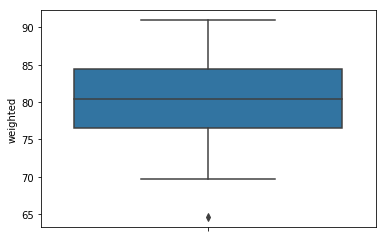

In [47]:
sns.boxplot(y=crr_by_hood['weighted'])

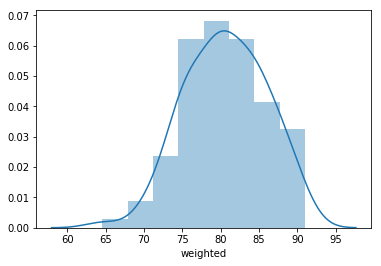

In [48]:
sns.distplot(crr_by_hood['weighted'])

Summary stats and visualizations show that Census Response Rate by neighborhood in PDX is somewhat normal with some left-skewing (at least visually). 

In [51]:
# flatten multilevel index dataframe and export census response rate to csv 

for_csv = pd.DataFrame(crr_by_hood.to_records())
for_csv.rename(columns={'weighted':'census_response_rate'}, inplace=True)
for_csv.head()
for_csv.to_csv("Data/neighborhood_census_response_rate.csv")

In [52]:
# merge the census response rates to neighborhood shapes for plotting
pdx_hoods = pdx_hoods.merge(for_csv, on='name', how='inner')

Text(0.5,1,'Census Response Rate by Neighborhood')

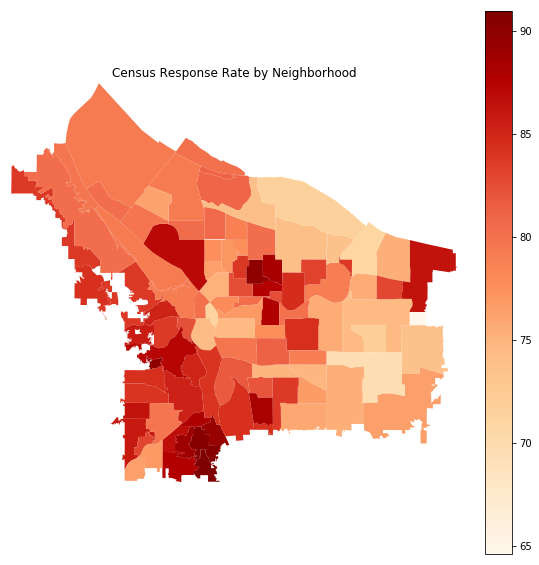

In [53]:
# plot choropleth of population by neighborhood unit

gplt.choropleth(pdx_hoods,
                hue=pdx_hoods['census_response_rate'],  # Display data, passed as a Series
                projection=gcrs.AlbersEqualArea(),
                cmap='OrRd',
                linewidth=0.5,
                k=None,
                legend=True,
                #scheme='equal_interval',
                figsize=(10, 10))

plt.title("Census Response Rate by Neighborhood")

These CRR numbers now look credible after erroneous deduping code was removed and Overlook was re-processed to calculate CRR after removing the CBG without any CRR data associated with it. When creating a future geo conversion tool, we should incorporate handling of these cases.